<a href="https://colab.research.google.com/github/amp77921/RL_Project/blob/main/MAPPO_Connect4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import numpy as np
import pandas as pd
from IPython.display import display

# Connect 4 class description
class connect_x:

    def __init__(self):
        self.board_height = 6
        self.board_width = 7
        self.board_state = np.zeros([self.board_height, self.board_width], dtype=np.int8)
        self.players = {'p1': 1, 'p2': 2}
        self.isDone = False
        self.reward = {'win': 1, 'draw': 0.5, 'lose': -1}

    def render(self):
        rendered_board_state = self.board_state.copy().astype(str)
        rendered_board_state[self.board_state == 0] = ' '
        rendered_board_state[self.board_state == 1] = 'O'
        rendered_board_state[self.board_state == 2] = 'X'
        display(pd.DataFrame(rendered_board_state))

    def reset(self):
        self.__init__()

    def get_available_actions(self):
        available_cols = []
        for j in range(self.board_width):
            if np.sum([self.board_state[:, j] == 0]) != 0:
                available_cols.append(j)
        return available_cols

    def check_game_done(self, player):
        if player == 'p1':
            check = '1 1 1 1'
        else:
            check = '2 2 2 2'

        # check vertically then horizontally
        for j in range(self.board_width):
            if check in np.array_str(self.board_state[:, j]):
                self.isDone = True
        for i in range(self.board_height):
            if check in np.array_str(self.board_state[i, :]):
                self.isDone = True

        # check left diagonal and right diagonal
        for k in range(0, self.board_height - 4 + 1):
            left_diagonal = np.array([self.board_state[k + d, d] for d in \
                            range(min(self.board_height - k, min(self.board_height, self.board_width)))])
            right_diagonal = np.array([self.board_state[d + k, self.board_width - d - 1] for d in \
                            range(min(self.board_height - k, min(self.board_height, self.board_width)))])
            if check in np.array_str(left_diagonal) or check in np.array_str(right_diagonal):
                self.isDone = True
        for k in range(1, self.board_width - 4 + 1):
            left_diagonal = np.array([self.board_state[d, d + k] for d in \
                            range(min(self.board_width - k, min(self.board_height, self.board_width)))])
            right_diagonal = np.array([self.board_state[d, self.board_width - 1 - k - d] for d in \
                            range(min(self.board_width - k, min(self.board_height, self.board_width)))])
            if check in np.array_str(left_diagonal) or check in np.array_str(right_diagonal):
                self.isDone = True

        if self.isDone:
            return self.reward['win']
        # check for draw
        elif np.sum([self.board_state == 0]) == 0:
            self.isDone = True
            return self.reward['draw']
        else:
            return 0.

    def make_move(self, a, player):
        # check if move is valid
        if a in self.get_available_actions():
            i = np.sum([self.board_state[:, a] == 0]) - 1
            self.board_state[i, a] = self.players[player]
        else:
            #print('Move is invalid') CHANGED
            self.render()

        reward = self.check_game_done(player)

        # give feedback as new state and reward
        return self.board_state.copy(), reward

env = connect_x()

In [39]:
import random

# Memory class for experience replay
class replayMemory:
    def __init__(self):
        self.memory = []

    def dump(self, transition_tuple):
        self.memory.append(transition_tuple)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

memory = replayMemory()

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Defining the Actor Critic Network
class Actor(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 128)
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=-1)
        return x

class Critic(nn.Module):
    def __init__(self, num_inputs):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 128)
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [77]:
# Updates value function for the PPO agent
def update_policy(state, action, reward, next_state, done, log_prob, actor, critic, optimizer_actor, optimizer_critic):
    state = torch.tensor(state.flatten(), dtype=torch.float32).unsqueeze(0).to(device)
    if next_state is not None:
        next_state = torch.tensor(next_state.flatten(), dtype=torch.float32).unsqueeze(0).to(device)
    action = torch.tensor([action], dtype=torch.long).to(device).unsqueeze(1)  # Unsqueeze to add the required second dimension
    reward = torch.tensor([reward], dtype=torch.float32).to(device)
    mask = torch.tensor([1.0 - float(done)], dtype=torch.float32).to(device)

    # Calculate expected value from critic
    pred_value = critic(state)
    next_pred_value = critic(next_state) if next_state is not None else 0.0

    # Calculate the advantage
    target_value = reward + (0.99 * next_pred_value * mask)
    target_value = target_value.view(-1, 1)
    advantage = target_value - pred_value

    # Calculate old and new log probabilities
    pred_probs = actor(state)
    pred_log_probs = torch.log(pred_probs.gather(1, action))  # Ensure action is correctly shaped [1, 1]

    # Ratio for PPO
    ratios = torch.exp(pred_log_probs - log_prob.unsqueeze(1))  # Ensure log_prob is also correctly shaped

    # Actor loss
    surr1 = ratios * advantage.detach()
    surr2 = torch.clamp(ratios, 1.0 - 0.2, 1.0 + 0.2) * advantage.detach()
    actor_loss = -torch.min(surr1, surr2).mean()

    # Critic loss
    critic_loss = F.mse_loss(pred_value, target_value.detach())

    # Optimization step
    optimizer_actor.zero_grad()
    optimizer_critic.zero_grad()
    actor_loss.backward()
    critic_loss.backward()
    optimizer_actor.step()
    optimizer_critic.step()

# Selects an action for the agent
def select_action(state, policy_net, steps_done, training=True):
    state = torch.tensor(state.flatten(), dtype=torch.float).unsqueeze(0).to(device)  # Flatten and add batch dimension
    with torch.no_grad():
        probabilities = policy_net(state)
    dist = torch.distributions.Categorical(probabilities)
    action = dist.sample().item()
    return action, dist.log_prob(torch.tensor([action]))

# random agent
def random_agent(actions):
    return random.choice(actions)

# win rate test
def win_rate_test():
    win_moves_taken_list = []
    win = []
    for i in range(100):
        env.reset()
        moves_taken = 0  # Initialize move count for each game
        while not env.isDone:
            state = env.board_state.copy()
            available_actions = env.get_available_actions()
            action, _ = select_action(state, actor_p1, steps_done, training=False)
            state, reward = env.make_move(action, 'p1')
            moves_taken += 1  # Increment move count here
            if env.isDone:
                if reward == 1:
                    win_moves_taken_list.append(moves_taken)  # Use local move count
                    win.append(1)
                break
    return sum(win) / 100, np.mean(win_moves_taken_list) if win_moves_taken_list else 0

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = connect_x()

In [79]:
import os
import pickle
import numpy as np
from google.colab import files

# Initialize actor and critic
actor_p1 = Actor(num_inputs=42, num_actions=env.board_width).to(device)
critic_p1 = Critic(num_inputs=42).to(device)
optimizer_actor_p1 = torch.optim.Adam(actor_p1.parameters(), lr=3e-4)
optimizer_critic_p1 = torch.optim.Adam(critic_p1.parameters(), lr=1e-3)

steps_done = 0
training_history = []
value_estimates_per_episode = []  # Tracking critic's value estimates
num_episodes = 10000 #20000

# Don't render the board state at all
env.silent = True
env.render_board = False
env._render_board = False
env.render = lambda: None

for i in range(num_episodes):
    env.reset()
    state_p1 = env.board_state.copy()
    max_value_estimate = float('-inf')  # Initialize the maximum value estimate for this episode to negative infinity

    if i % 20 == 0 and i > 0:
        win_rate, moves_taken = win_rate_test()
        training_history.append([i + 1, win_rate, moves_taken])
        th = np.array(training_history)
        if i % 200 == 0:
            print('Episode {}: | win_rate: {} | moves_taken: {}'.format(i, th[-1, 1], th[-1, 2]))

    while not env.isDone:
        available_actions = env.get_available_actions()
        action_p1, log_prob_p1 = select_action(state_p1, actor_p1, steps_done)
        steps_done += 1
        state_p1_, reward_p1 = env.make_move(action_p1, 'p1')

        # Get the current value estimate from the critic for logging purposes
        current_value_estimate = critic_p1(torch.from_numpy(state_p1.flatten()).float().unsqueeze(0).to(device))
        max_value_estimate = max(max_value_estimate, current_value_estimate.item())  # Update max value estimate

        if env.isDone:
            update_policy(state_p1, action_p1, reward_p1, None, True, log_prob_p1, actor_p1, critic_p1, optimizer_actor_p1, optimizer_critic_p1)
            break

        action_p2 = random.choice(available_actions)  # Second player acts randomly
        state_p2_, reward_p2 = env.make_move(action_p2, 'p2')

        if env.isDone:
            update_policy(state_p1, action_p1, reward_p2, None, True, log_prob_p1, actor_p1, critic_p1, optimizer_actor_p1, optimizer_critic_p1)
            break

        update_policy(state_p1, action_p1, -0.05, state_p2_, False, log_prob_p1, actor_p1, critic_p1, optimizer_actor_p1, optimizer_critic_p1)
        state_p1 = state_p2_

    if max_value_estimate == float('-inf'):
        max_value_estimate = 0

    # Log the highest value estimate encountered during the episode
    value_estimates_per_episode.append(max_value_estimate)

# File path
file_path = 'q_values_mappo_ra.pkl'

# Check if the file already exists
if os.path.exists(file_path):
    os.remove(file_path)  # Remove the file if it exists

# Save the new maximum values to the file
with open(file_path, 'wb') as f:
    pickle.dump(value_estimates_per_episode, f)

# Download the file
files.download(file_path)

print('Complete')

Episode 200: | win_rate: 1.0 | moves_taken: 7.8
Episode 400: | win_rate: 1.0 | moves_taken: 7.27
Episode 600: | win_rate: 1.0 | moves_taken: 7.94
Episode 800: | win_rate: 1.0 | moves_taken: 7.15
Episode 1000: | win_rate: 1.0 | moves_taken: 7.32
Episode 1200: | win_rate: 1.0 | moves_taken: 7.4
Episode 1400: | win_rate: 1.0 | moves_taken: 7.12
Episode 1600: | win_rate: 1.0 | moves_taken: 6.86
Episode 1800: | win_rate: 1.0 | moves_taken: 7.6
Episode 2000: | win_rate: 1.0 | moves_taken: 6.99
Episode 2200: | win_rate: 1.0 | moves_taken: 6.8
Episode 2400: | win_rate: 1.0 | moves_taken: 6.47
Episode 2600: | win_rate: 1.0 | moves_taken: 6.46
Episode 2800: | win_rate: 1.0 | moves_taken: 6.8
Episode 3000: | win_rate: 1.0 | moves_taken: 6.95
Episode 3200: | win_rate: 1.0 | moves_taken: 6.16
Episode 3400: | win_rate: 1.0 | moves_taken: 5.91
Episode 3600: | win_rate: 1.0 | moves_taken: 5.89
Episode 3800: | win_rate: 1.0 | moves_taken: 6.01
Episode 4000: | win_rate: 1.0 | moves_taken: 5.71
Episode 4

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Complete


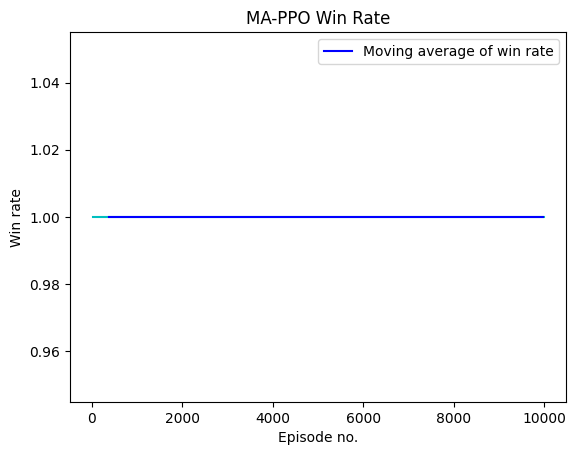

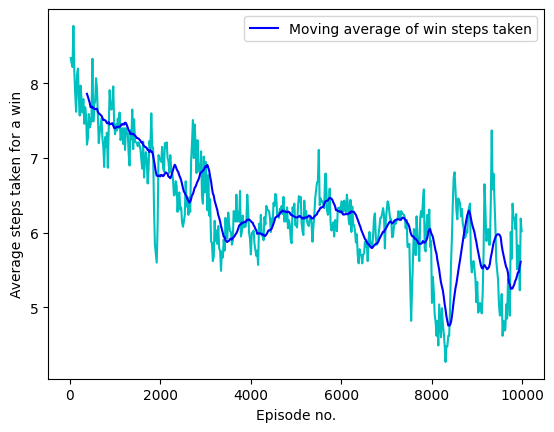

In [80]:
import matplotlib.pyplot as plt

# Plotting logic here
plt.plot(th[:, 0], th[:, 1], c='c')
win_rate_moving_average = np.array([[(i + 19) * 20, np.mean(th[i: i + 20, 1])] for i in range(len(th) - 19)])
plt.plot(win_rate_moving_average[:, 0], win_rate_moving_average[:, 1], c='b', label='Moving average of win rate')
plt.legend()
plt.title('MA-PPO Win Rate')
plt.xlabel('Episode no.')
plt.ylabel('Win rate')
plt.show()

plt.plot(th[:, 0], th[:, 2], c='c')
win_steps_taken_moving_average = np.array([[(i + 19) * 20, np.mean(th[i: i + 20, 2])] for i in range(len(th) - 19)])
plt.plot(win_steps_taken_moving_average[:, 0], win_steps_taken_moving_average[:, 1], c='b', label='Moving average of win steps taken')
plt.legend()
plt.xlabel('Episode no.')
plt.ylabel('Average steps taken for a win')
plt.show()

In [42]:
# Multi Agent PPO

import numpy as np
import torch
import os
import pickle
from google.colab import files
from itertools import count
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import StepLR


def weights_init(m):
    if isinstance(m, nn.Linear):  # Check if the module is a linear layer
        torch.nn.init.xavier_uniform_(m.weight)  # Apply Xavier uniform initialization
        m.bias.data.fill_(0.01)  # Set biases to 0.01

# Initialize actors and critics
actor_p1 = Actor(num_inputs=42, num_actions=env.board_width).to(device)
critic_p1 = Critic(num_inputs=42).to(device)
actor_p1.apply(weights_init)  # Apply the custom weights initialization
critic_p1.apply(weights_init)  # Apply the custom weights initialization

actor_p2 = Actor(num_inputs=42, num_actions=env.board_width).to(device)
critic_p2 = Critic(num_inputs=42).to(device)
actor_p2.apply(weights_init)  # Apply the custom weights initialization
critic_p2.apply(weights_init)  # Apply the custom weights initialization

# Initialize optimizers
optimizer_actor_p1 = torch.optim.Adam(actor_p1.parameters(), lr=3e-4)
optimizer_critic_p1 = torch.optim.Adam(critic_p1.parameters(), lr=1e-3)
scheduler_actor_p1 = StepLR(optimizer_actor_p1, step_size=1000, gamma=0.9)
scheduler_critic_p1 = StepLR(optimizer_critic_p1, step_size=1000, gamma=0.9)

optimizer_actor_p2 = torch.optim.Adam(actor_p2.parameters(), lr=3e-4)
optimizer_critic_p2 = torch.optim.Adam(critic_p2.parameters(), lr=1e-3)
scheduler_actor_p2 = StepLR(optimizer_actor_p2, step_size=1000, gamma=0.9)
scheduler_critic_p2 = StepLR(optimizer_critic_p2, step_size=1000, gamma=0.9)

# Selects an action based on the value function
def select_action(state, actor):
    # Flatten the state to ensure it's a 1D tensor with 42 elements
    state = state.flatten() if state.ndim > 1 else state
    #print("Shape of state before feeding to actor:", state.shape)  # Debugging line
    state_tensor = torch.tensor(state, dtype=torch.float, device=device).unsqueeze(0)

    with torch.no_grad():
        action_probs = actor(state_tensor)
    m = torch.distributions.Categorical(action_probs)
    action = m.sample()
    return action.item(), m.log_prob(action)

# Updates the value function for the multi agent PPO
def update_ma_policy(state, action, reward, next_state, done, log_prob, actor, critic, optimizer_actor, optimizer_critic, retain_graph=False):
    # Convert state to the correct tensor format
    state_tensor = torch.tensor(state.flatten(), dtype=torch.float32, device=device)
    if next_state is not None:
        next_state_tensor = torch.tensor(next_state.flatten(), dtype=torch.float32, device=device)
    else:
        next_state_tensor = torch.zeros_like(state_tensor)

    action_tensor = torch.tensor([action], dtype=torch.long, device=device)
    reward_tensor = torch.tensor([reward], dtype=torch.float32, device=device)

    # Get predictions from the critic network
    pred_value = critic(state_tensor)
    next_pred_value = critic(next_state_tensor) if next_state is not None else torch.zeros(1, device=device)

    # Calculate target value without gradient tracking
    target_value = reward_tensor + 0.99 * next_pred_value.detach() * (1 - int(done))
    critic_loss = F.mse_loss(pred_value, target_value)

    # Get action probabilities and calculate entropy
    action_probs = actor(state_tensor)
    if action_probs.dim() == 1:
        action_probs = action_probs.unsqueeze(0)  # Add batch dimension if it's not present
    entropy = -(action_probs * torch.log(action_probs + 1e-10)).sum(dim=1).mean()

    # Calculate actor loss using advantage and entropy to encourage exploration
    advantage = (target_value.detach() - pred_value)
    actor_loss = -(log_prob * advantage).mean() - 0.01 * entropy

    # Perform gradient update for actor
    optimizer_actor.zero_grad()
    actor_loss.backward(retain_graph=True)
    clip_grad_norm_(actor.parameters(), max_norm=1.0)  # Apply gradient clipping to actor
    optimizer_actor.step()

    # Perform gradient update for critic
    optimizer_critic.zero_grad()
    critic_loss.backward()
    clip_grad_norm_(critic.parameters(), max_norm=1.0)  # Apply gradient clipping to critic
    optimizer_critic.step()

    return pred_value.item()

# Evaluate the win rate of the agents
def evaluate_win_rate(agent, opponent, num_games=100):
    wins = 0
    total_moves = 0  # Keep track of the total moves for all games

    for _ in range(num_games):
        env.reset()
        state = env.board_state.copy().flatten()
        done = False
        moves = 0  # Track moves per game

        while not done:
            action, log_prob = select_action(state, agent)  # Adjusted to receive only two values
            state, reward = env.make_move(action, 'p1')
            moves += 1  # Increment moves count here
            done = env.isDone

            if not done:
                opponent_action, opponent_log_prob = select_action(state, opponent)  # Likewise here
                state, _ = env.make_move(opponent_action, 'p2')
                moves += 1  # Increment moves count for opponent move
                done = env.isDone

        total_moves += moves  # Add the moves count for this game to the total
        if reward == env.reward['win']:
            wins += 1

    win_rate = wins / num_games
    average_moves = total_moves / num_games if num_games > 0 else 0  # Calculate average moves per game
    return win_rate, average_moves

steps_done = 0
MA_training_history = []
value_estimates_per_episode = []  # Tracking critic's value estimates

num_episodes = 10000
evaluation_interval = 20
detailed_evaluation_interval = 200

# Don't render the board state at all
env.silent = True
env.render_board = False
env._render_board = False
env.render = lambda: None

# Main training loop
for i in range(num_episodes):
    env.reset()
    state = env.board_state.copy().flatten()
    max_value_estimate = float('-inf')

    while not env.isDone:
        available_actions = env.get_available_actions()
        action, log_prob = select_action(state, actor_p1)
        next_state, reward = env.make_move(action, 'p1')
        if env.isDone:
            value_estimate = update_ma_policy(state, action, reward, None, True, log_prob, actor_p1, critic_p1, optimizer_actor_p1, optimizer_critic_p1)
            max_value_estimate = max(max_value_estimate, value_estimate)
            break

        value_estimate = update_ma_policy(state, action, reward, next_state, False, log_prob, actor_p1, critic_p1, optimizer_actor_p1, optimizer_critic_p1)
        max_value_estimate = max(max_value_estimate, value_estimate)
        state = next_state

        # Second agent acts
        action, log_prob = select_action(state, actor_p2)
        next_state, reward = env.make_move(action, 'p2')
        value_estimate = update_ma_policy(state, action, reward, next_state, env.isDone, log_prob, actor_p2, critic_p2, optimizer_actor_p2, optimizer_critic_p2)
        max_value_estimate = max(max_value_estimate, value_estimate)
        state = next_state

    if max_value_estimate == float('-inf'):
        max_value_estimate = 0

    value_estimates_per_episode.append(max_value_estimate)

    # Scheduler step
    scheduler_actor_p1.step()
    scheduler_critic_p1.step()
    scheduler_actor_p2.step()
    scheduler_critic_p2.step()

    # Save training history
    if i % detailed_evaluation_interval == 0:
        win_rate, moves_taken = evaluate_win_rate(actor_p1, actor_p2)
        MA_training_history.append([i, win_rate, moves_taken])
        print(f'Episode {i}: | Win rate: {win_rate} | Moves taken: {moves_taken}')

# File path
file_path = 'q_values_mappo_ma.pkl'

# Check if the file already exists
if os.path.exists(file_path):
    os.remove(file_path)  # Remove the file if it exists

# Save the new maximum values to the file
with open(file_path, 'wb') as f:
    pickle.dump(value_estimates_per_episode, f)

# Download the file
files.download(file_path)

print('Complete')

Episode 0: | Win rate: 0.5 | Moves taken: 23.74
Episode 200: | Win rate: 0.57 | Moves taken: 22.83
Episode 400: | Win rate: 0.58 | Moves taken: 22.08
Episode 600: | Win rate: 0.55 | Moves taken: 24.13
Episode 800: | Win rate: 0.6 | Moves taken: 22.04
Episode 1000: | Win rate: 0.57 | Moves taken: 22.63
Episode 1200: | Win rate: 0.53 | Moves taken: 21.41
Episode 1400: | Win rate: 0.51 | Moves taken: 24.15
Episode 1600: | Win rate: 0.61 | Moves taken: 21.43
Episode 1800: | Win rate: 0.46 | Moves taken: 23.46
Episode 2000: | Win rate: 0.64 | Moves taken: 21.84
Episode 2200: | Win rate: 0.5 | Moves taken: 22.2
Episode 2400: | Win rate: 0.52 | Moves taken: 21.5
Episode 2600: | Win rate: 0.54 | Moves taken: 22.8
Episode 2800: | Win rate: 0.56 | Moves taken: 22.56
Episode 3000: | Win rate: 0.62 | Moves taken: 22.59
Episode 3200: | Win rate: 0.51 | Moves taken: 23.79
Episode 3400: | Win rate: 0.53 | Moves taken: 22.59
Episode 3600: | Win rate: 0.53 | Moves taken: 22.61
Episode 3800: | Win rate:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Complete


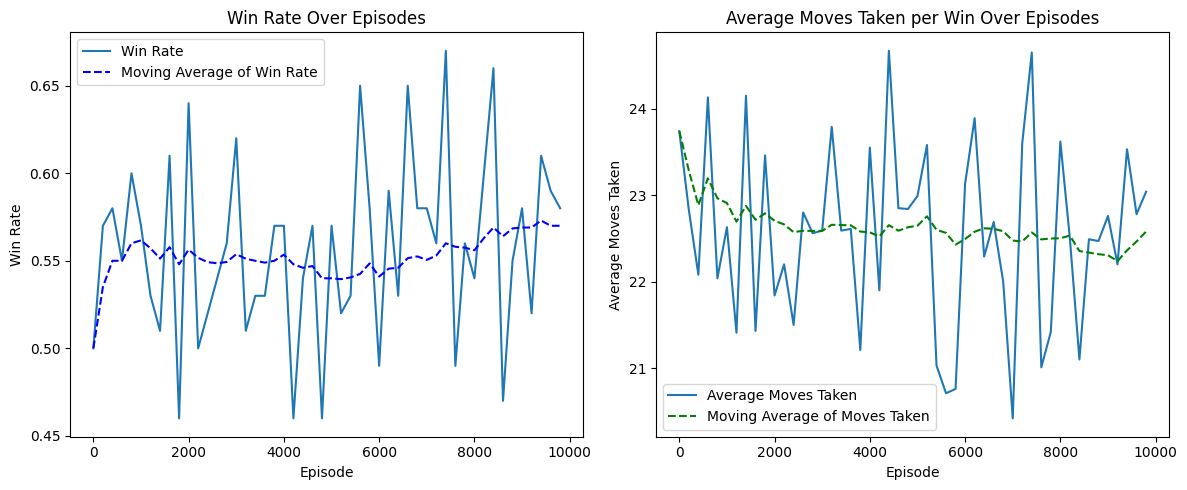

In [45]:
import matplotlib.pyplot as plt

MA_training_history = np.array(MA_training_history)

# Plot Win Rates
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(MA_training_history[:, 0], MA_training_history[:, 1], label='Win Rate')
win_rate_moving_average = np.array([np.mean(MA_training_history[max(0, i-19):i+1, 1]) for i in range(len(MA_training_history))])
plt.plot(MA_training_history[:, 0], win_rate_moving_average, color='blue', linestyle='--', label='Moving Average of Win Rate')
plt.title('Win Rate Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Win Rate')
plt.legend()

# Plot Average Moves Taken
plt.subplot(1, 2, 2)
plt.plot(MA_training_history[:, 0], MA_training_history[:, 2], label='Average Moves Taken')
moves_taken_moving_average = np.array([np.mean(MA_training_history[max(0, i-19):i+1, 2]) for i in range(len(MA_training_history))])
plt.plot(MA_training_history[:, 0], moves_taken_moving_average, color='green', linestyle='--', label='Moving Average of Moves Taken')
plt.title('Average Moves Taken per Win Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Average Moves Taken')
plt.legend()

plt.tight_layout()
plt.show()